In [1]:
import numpy as np
from numpy import pi
from qiskit import *
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector

C:\Users\nico_\Anaconda3\lib\site-packages\qiskit\__init__.py:66: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of qiskit-terra 0.17.0. Support for running Qiskit with Python 3.6 will be removed in qiskit-terra 0.20.0.
  DeprecationWarning,


In [21]:
#functions for qft circuit

#cp(theta,c,t) are controlled rotation of angle theta controlled by 'c' on target 't'
def qft_rot(qc,n):
    if n==0:
        return qc
    n -= 1
    qc.h(n)
    for q in range(n):
        qc.cp(pi/(2**(n-q)),q,n)
    #applies H and rotation iteratively to every q bit from the most significant to the least sig.
    qft_rot(qc,n)

def swap_register(qc,n):
    for q in range(n//2):
        qc.swap(q,n-1-q)
    return qc

def qft(qc,n):
    qft_rot(qc,n)
    qc.barrier()
    swap_register(qc,n)
    return qc
    
#inverse qft
#append an inverse qft circuit to the first n q bits of an existing one
def inv_qft(qc,n):
    dum_circ = qft(QuantumCircuit(n),n)
    dum_circ = dum_circ.inverse()#invert i.e takes the adjoint
    #now append the inverse qft circuit (qft_circ) to qc
    qc.append(dum_circ,qc.qubits[:n])
    return qc.decompose()


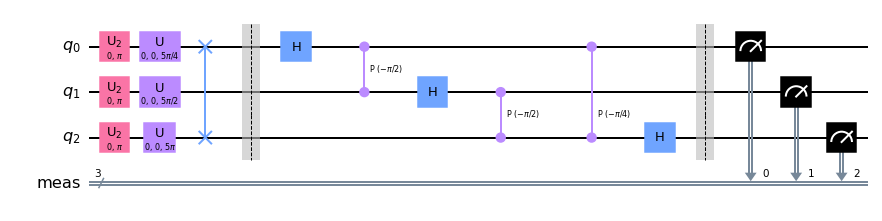

In [23]:
n=3
x=5
qc = QuantumCircuit(n)
for q in range(n):
    qc.h(q)
qc.p(x*pi/4,0)
qc.p(x*pi/2,1)
qc.p(x*pi,2)

qc = inv_qft(qc,n)
qc.measure_all()
qc.draw(output='mpl')

In [29]:
#IBMQ.save_account('5683dfe27b8f0a6ff699b7339c005f5fcbd05eedcda663a1b32f82efb5d82672547b1b7bb86d5017b25c596bf25c3ecc821cce8efaa3fee86fc9dd2fe14b98b9')
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

configrc.store_credentials:WARNING:2021-11-24 20:22:34,910: Credentials already present. Set overwrite=True to overwrite.
ibmqfactory.load_account:WARNING:2021-11-24 20:22:35,429: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_bogota


Job Status: job has successfully run


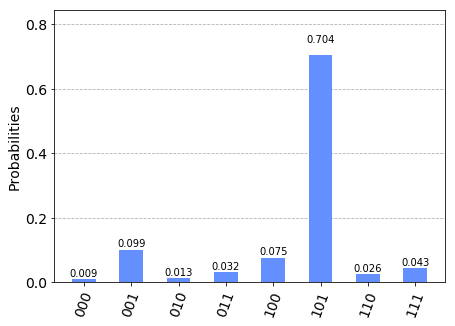

In [30]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)

counts = job.result().get_counts()
plot_histogram(counts)